## Import Packages and Data

In [1]:
import numpy as np
import pandas as pd
import re, nltk, gensim
import spacy
#import en_core_web_sm

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\nholl\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\nholl\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\nholl\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
#Reading in the dataset 
# this will need to be changed to imort data from Mongodb
colnames = ['Review', 'Review_Date', 'Review_Rating']
df = pd.read_csv('hotelreviews.csv')
df.head(5)


,Review,Review_Date,Review_Rating
0,We have spent a couple of weeks touring round ...,"November 24, 2018",5
1,In town for Ed Sheeran concert. Room very good...,"November 17, 2018",4
2,Our room was large and clean with an excellent...,"November 12, 2018",5
3,The hotel is located in a very busy street of ...,"November 7, 2018",4
4,Wingate is great for several reasons. I partic...,"November 6, 2018",5


---

### Cleaning Text for Analysis

In [ ]:
#Converting all of the posts into a list so that LDA can put them into topics

data=df["Review"].tolist()
data[:3]

In [4]:
#Cleaning all of the posts by removing all stopwords and other cleaning processes via the gensim package
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

print(data_words[:3])

[['we', 'have', 'spent', 'couple', 'of', 'weeks', 'touring', 'round', 'small', 'part', 'of', 'the', 'united', 'states', 'and', 'have', 'now', 'used', 'wingate', 'by', 'wyndham', 'on', 'three', 'occasions', 'and', 'every', 'experience', 'has', 'been', 'excellent', 'will', 'definitely', 'use', 'them', 'again', 'on', 'future', 'visits', 'brilliant', 'welcome', 'at', 'reception', 'happy', 'and', 'smiley', 'which', 'is', 'always', 'very', 'welcome', 'and', 'also', 'terrifically', 'helpful', 'lovely', 'room', 'immaculate', 'in', 'every', 'way', 'and', 'beautiful', 'bedding', 'and', 'towels', 'if', 'you', 'haven', 'tried', 'stay', 'in', 'one', 'of', 'their', 'hotels', 'then', 'suggest', 'you', 'try', 'because', 'they', 'have', 'made', 'me', 'very', 'happy', 'and', 'satisfied', 'client', 'keep', 'up', 'the', 'great', 'work', 'and', 'the', 'very', 'high', 'standards', 'thank', 'you', 'for', 'nice', 'stay'], ['in', 'town', 'for', 'ed', 'sheeran', 'concert', 'room', 'very', 'good', 'comfortable',

In [5]:
nlp = spacy.load('en')

C:\Users\nholl\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Users\nholl\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [6]:
#Lemmtizing the data so that only nouns, adjectives, verbs, and adverbs are in the text 

import en_core_web_sm

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['have spend couple week tour small part united state have now use wingate wyndham occasion experience have be excellent will definitely use again future visit brilliant welcome reception happy smiley which be always very welcome also terrifically helpful lovely room immaculate way beautiful bedding towel haven try stay  hotel then suggest try have make very happy satisfied client keep great work very high standard thank nice stay', 'town ed sheeran concert room very good comfortable breakfast good have have hotel maid service be little slow left hour room have not be service be good guest service person ever very helpful friendly go  way help would stay again']


---

### Building the Model

In [ ]:
#Vectorizing the data using the scikit CountVectorizer method
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        
                             stop_words='english',            
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',      
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [101]:
#Creating the lda model 
lda_model = LatentDirichletAllocation(n_components=5,              
                                      max_iter=10,      
                                      learning_method='online',   
                                      batch_size=150,            
                                      evaluate_every = -1,      
                                      n_jobs = -1,
                                      random_state=432
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)

LatentDirichletAllocation(batch_size=150, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=432, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [102]:
print(lda_output)

[[0.00402463 0.00400605 0.09506892 0.00403284 0.89286756]
 [0.00743271 0.05868936 0.007416   0.00742326 0.91903867]
 [0.00426507 0.00427856 0.00425697 0.00430956 0.98288984]
 ...
 [0.00555642 0.00566047 0.005556   0.0056195  0.97760762]
 [0.00185247 0.67595379 0.00185193 0.00188369 0.31845812]
 [0.00364017 0.00365441 0.00363689 0.07849973 0.91056881]]


---

### Visualizations

#### Topic Distributions

In [103]:
'''
Printing of Influencial topics per document
'''

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0,0,0.1,0,0.89,4
Doc1,0.01,0.06,0.01,0.01,0.92,4
Doc2,0,0,0,0,0.98,4
Doc3,0,0,0,0.01,0.99,4
Doc4,0,0,0,0,0.99,4
Doc5,0.01,0.01,0.01,0.01,0.98,4
Doc6,0,0,0.09,0,0.9,4
Doc7,0,0,0,0,0.99,4
Doc8,0.76,0.01,0.01,0.01,0.22,0
Doc9,0.01,0.09,0.01,0.01,0.87,4


In [92]:
writer = pd.ExcelWriter('Doc_Topics.xlsx')
df_document_topic.to_excel(writer,'Sheet1')
writer.save()

In [93]:
#doc_topics = pd.read_csv('Doc_Topics.csv', index_col=0)
doc_topics = pd.read_excel('Doc_Topics.xlsx', sheet_name='Sheet1')

#### Dominant Topic Frequencies

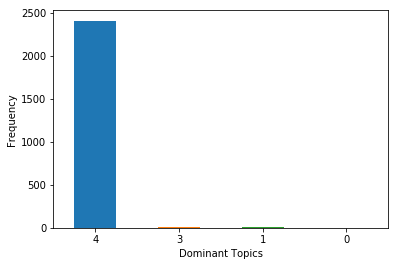

In [105]:
doc_topics['dominant_topic'] = doc_topics['dominant_topic'].astype(str)

ax = doc_topics['dominant_topic'].value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Dominant Topics')
ax.set_ylabel('Frequency')
plt.savefig('FrequencyDominantTopic.png')

#### Review Rating Frequencies

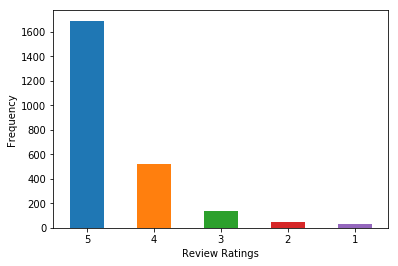

In [122]:
ax = df['Review_Rating'].value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Review Ratings')
ax.set_ylabel('Frequency')
plt.savefig('FrequencyRatings.png')

#### Word Cloud of All Reviews

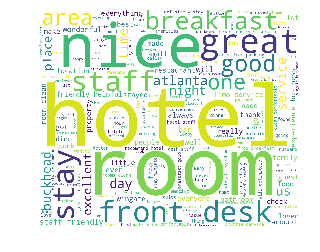

In [121]:
from wordcloud import WordCloud, STOPWORDS

review_string_list = [j for i in data_words for j in i]
review_string = ' '.join(review_string_list)

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000
                         ).generate(review_string)


plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud.to_file('Wordcloud.png')

#### Interactive Visualizations of Topics

In [107]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\nholl\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      14.099281 -80.850639       1        1  91.181756
3      21.249826  29.797745       2        1   3.776404
0      67.051125 -44.093674       3        1   1.929921
1     -16.988955 -21.858963       4        1   1.566743
2      86.747284  17.282381       5        1   1.545176, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
4380  Default  2480.000000          room  2480.000000  30.0000  30.0000
3718  Default   280.000000       parking   280.000000  29.0000  29.0000
3180  Default   188.000000       marquis   188.000000  28.0000  28.0000
3070  Default   211.000000           lot   211.000000  27.0000  27.0000
5120  Default   175.000000         thank   175.000000  26.0000  26.0000
2369  Default   200.000000         guest   200.000000  25.0000  25.0000
758   Default   120.000000           car   120.000000  24.0000  24.0000
4334  Default   162.000000        review   162.000000  23.0000  23.0000
224   Default   119.000000       anthony   119.000000  22.0000  22.0000
764   Default   111.000000          care   111.000000  21.0000  21.0000
3475  Default   109.000000         noise   109.000000  20.0000  20.0000
5095  Default   136.000000          tell   136.000000  19.0000  19.0000
4465  Default   273.000000           say   273.000000  18.0000  18.0000
4114  Default   124.000000          rate   124.000000  17.0000  17.0000
4285  Default    98.000000   reservation    98.000000  16.0000  16.0000
4785  Default    87.000000       special    87.000000  15.0000  15.0000
5295  Default   132.000000           try   132.000000  14.0000  14.0000
5567  Default    90.000000         water    90.000000  13.0000  13.0000
124   Default    74.000000           air    74.000000  12.0000  12.0000
2445  Default    82.000000          hear    82.000000  11.0000  11.0000
584   Default   173.000000          book   173.000000  10.0000  10.0000
3235  Default    70.000000       meeting    70.000000   9.0000   9.0000
5140  Default   136.000000         think   136.000000   8.0000   8.0000
2798  Default   105.000000         issue   105.000000   7.0000   7.0000
2066  Default   371.000000         floor   371.000000   6.0000   6.0000
5305  Default    68.000000          turn    68.000000   5.0000   5.0000
4357  Default    72.000000          road    72.000000   4.0000   4.0000
411   Default    67.000000           bad    67.000000   3.0000   3.0000
2761  Default   130.000000      internet   130.000000   2.0000   2.0000
1577  Default   111.000000           don   111.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
830    Topic5     2.876948  championship     3.477737   3.9804  -6.2278
4766   Topic5     2.823956     southeast     3.425300   3.9770  -6.2464
5135   Topic5     2.725291           thi     3.327795   3.9703  -6.2820
5306   Topic5     2.815507        turner     3.458094   3.9645  -6.2494
4748   Topic5     2.753000         soooo     3.385220   3.9633  -6.2719
1181   Topic5     2.490098          copy     3.099437   3.9511  -6.3722
5028   Topic5     2.404949          suvs     3.006601   3.9468  -6.4070
2386   Topic5     2.365674       halfway     2.967172   3.9435  -6.4235
520    Topic5     2.365469        bertha     2.967324   3.9433  -6.4236
2591   Topic5     2.364695      humberto     2.967661   3.9429  -6.4239
352    Topic5     2.309542       attract     2.911015   3.9386  -6.4475
121    Topic5     2.303926          ahve     2.909916   3.9365  -6.4499
447    Topic5     2.698619     baseboard     3.408610   3.9365  -6.2918
295    Topic5     2.243166           art     2.844800   3.9324  -6.4767
5238   Topic5     2.310876         trade     2.932205   3.9319  -6.4469
2480   Topic5     2.373748     heriberto     3.017625   3.9300  -6.4201
177    Topic5     2.222401    ambassa

In [108]:
pyLDAvis.save_html(data=panel, fileobj='LDA.html')

#### Top 15 words per Topic

In [109]:
'''
Top 15 Keywords per Topic
'''

# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,anthony,marquis,thank,guest,etienne,meeting,require,movie,care,special,team,duty,owner,forward,memorable
Topic 1,car,camera,security,parking,lot,near,sign,terrible,lift,waiver,respond,warn,police,turn,phipps
Topic 2,realize,rock,research,anthony,brand,listen,cadillac,wonder,fix,traveler,surpass,field,seriously,navigator,groupon
Topic 3,air,loud,room,review,hear,noise,reservation,luxury,water,speak,non,tell,rate,unit,inn
Topic 4,hotel,room,stay,staff,breakfast,great,good,nice,service,clean,make,atlanta,free,friendly,wingate


---

### Model Performance Analysis

C:\Users\nholl\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\nholl\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\nholl\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\nholl\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

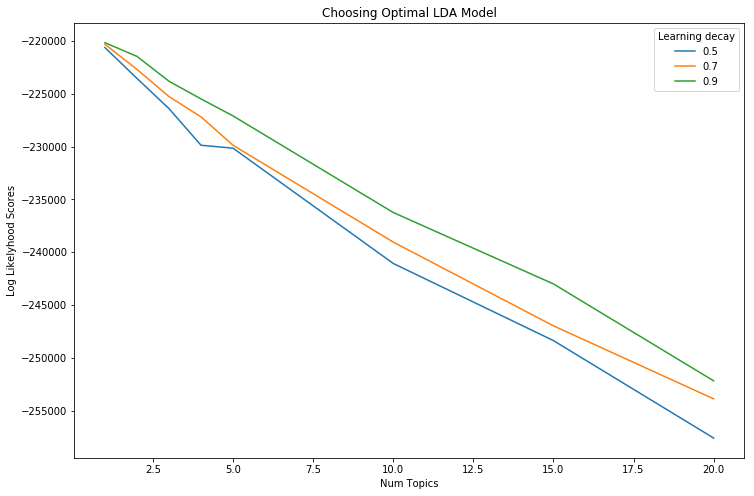

In [13]:
# Do the Grid Search
search_params = {'n_components': [1,2,3,4,5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized)

# Get Log Likelyhoods from Grid Search Output
n_topics = [1,2,3,4,5, 10, 15, 20]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()